# MS-AAI-501: Intro to AI
## Final Project:  Airline Flight Delay Analysis and Modeling
### File Name:  Logistic Regression.jpynb
### Date:  12/4/2023
### Author:  Ned Kost

In [3]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import category_encoders as ce


In [4]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()

# Reducing dimensionality of Categorical variables 
def binary_encode(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

def calculate_crsDeptTime(dept, delay):
    s = str(int(dept))
    if(len(s) < 3):
        t =  dt.timedelta(hours=0, minutes=int(dept))
    if(len(s) == 3):
        t =  dt.timedelta(hours=int(s[0]), minutes=int(s[-2:]))
    if(len(s) > 3):
        t =  dt.timedelta(hours=int(s[:2]), minutes=int(s[-2:]))
    delta = (t - dt.timedelta(minutes=int(delay)))
    result = days_hours_minutes(delta)
    return(float(str(result[1]) + (str(result[2]))))


# Data Loading and Preprocessing

In [4]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# 5) Calculate CRSDepTime as Actual Departure Time minus Departure Delay
flights_df['CRSDepTime'] = flights_df.apply(lambda x: calculate_crsDeptTime(x['DepTime'], x['DepDelay']), axis=1)

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,...,Origin_Precip,Dest_Windspeed,Dest_Precip,dest_ianaTimeZone,origin_ianaTimeZone,Aircraft_Daily_Flight_Count,FlightDateDT,DepTarmacTime,ArrTarmacTime,CRSDepTime
0,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N407AN,664.0,KOA,...,0.08,0.0,0.0,America/Phoenix,America/Los_Angeles,1,2020-01-01,900.0,360.0,2355.0
1,2020.0,1.0,1.0,1.0,3.0,2020-01-01,9E,N297PQ,5270.0,LFT,...,0.00,5.0,0.0,America/New_York,America/Chicago,1,2020-01-01,900.0,420.0,60.0
2,2020.0,1.0,1.0,1.0,3.0,2020-01-01,WN,N963WN,1395.0,CMH,...,0.00,7.0,0.0,America/Chicago,America/New_York,1,2020-01-01,540.0,300.0,555.0
3,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N891NN,137.0,TUS,...,0.00,8.0,0.0,America/Chicago,America/Phoenix,1,2020-01-01,1200.0,840.0,60.0
4,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N807AW,2189.0,SAT,...,0.00,12.0,0.0,America/Chicago,America/Chicago,1,2020-01-01,660.0,960.0,610.0


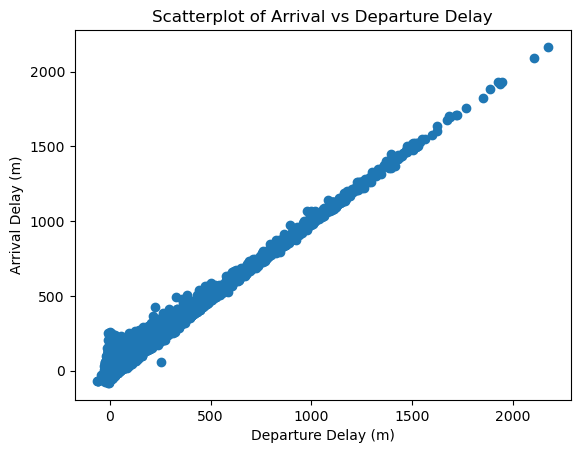

Data shows a strong linear relationship between Arrival Delay and Departuer Delay.


In [5]:
# Display Scatterplot of Arrival Delay vs. Departuer Delay
plt.scatter(flights_df['DepDelay'], flights_df['ArrDelay'])
plt.xlabel('Departure Delay (m)')
plt.ylabel('Arrival Delay (m)')
plt.title('Scatterplot of Arrival vs Departure Delay')
plt.show()

print('Data shows a strong linear relationship between Arrival Delay and Departuer Delay.')

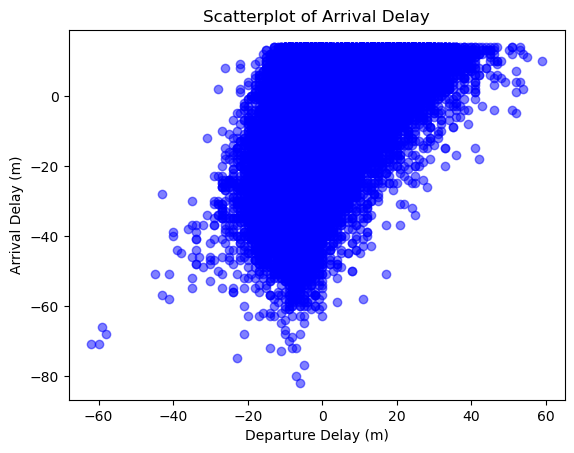

In [6]:
# Separate sample dataset into delayed and ontime
delayed_df = flights_df[flights_df['Delayed']==1]
ontime_df = flights_df[flights_df['Delayed']==0]

# Display Scatterplot of Arrival Delay 
plt.scatter(ontime_df['DepDelay'], ontime_df['ArrDelay'], color='blue', alpha=.5)
plt.xlabel('Departure Delay (m)')
plt.ylabel('Arrival Delay (m)')
plt.title('Scatterplot of Arrival Delay')
plt.show()


# Logistic Regression with only DepDelay

In [7]:
# Build function to initialize, test, and train model
#   INPUT:  df = dataframe to use with the model
#   INPUT:  features = feature list to use with the mdoel
#   OUTPUT:  Logistic Regression Model trained and tested
def run_logreg_model(df, features):
    # Declare X and Y from dataframe
    x = flights_df[features]
    y = flights_df['Delayed']

     # Encoding categorical variables
    if  'origin_ianaTimeZone' in features:
        x = binary_encode(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
        x = pd.get_dummies(x, columns=['Carrier'])
    else:
        if 'Dest' in features:
            x = binary_encode(x, ['Dest', 'Origin'])
            x = pd.get_dummies(x, columns=['Carrier'])
    
    # Split datset into Test / Train datasets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    # Initiate the GLM Model, fit it to data, and output the summary
    glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
    print(glm_binom_model.summary())

    # Predict probability that given y value is 1
    y_predict = glm_binom_model.predict(x_test)

    # Calculate and print out AUC of model
    auc = roc_auc_score(y_test, y_predict)
    print('(AUC) GLM Logistic Regression: %.4f' % auc)
    
    # Calculate AUC metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)

    # create ROC curve
    plt.plot(fpr, tpr)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC for Predicting Injury")
    plt.show()
    
    return glm_binom_model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257339
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0839e+05
Date:                Tue, 05 Dec 2023   Deviance:                   2.1679e+05
Time:                        15:10:33   Pearson chi2:                 2.26e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.4195
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DepDelay       0.1124      0.001    183.687      0.0

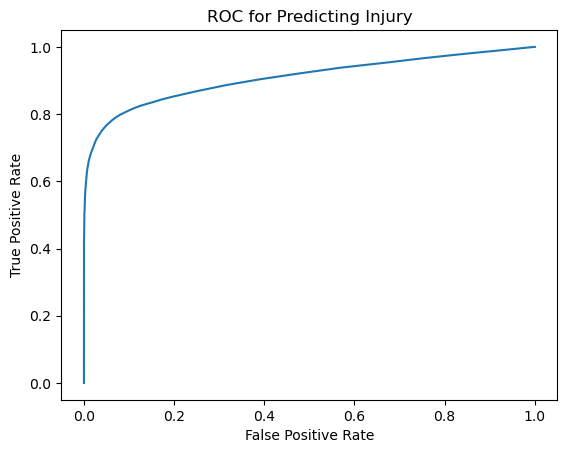


The strong Linear relationship between Departure Delay (DepDelay) and Arrival Delay (ArrDelay) provides a 90.8% AUC score.


In [8]:
# Use Departure Delay as sole Feature
features = ['DepDelay']

# Run Logistic Regression Model using departure delay only
binom_model = run_logreg_model(flights_df, features)


print('')
print('The strong Linear relationship between Departure Delay (DepDelay) and Arrival Delay (ArrDelay) provides a 90.8% AUC score.')

# Logistic Regression with Feature Set 1, 2, and 3

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257279
Model Family:                Binomial   Df Model:                           60
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64644.
Date:                Tue, 05 Dec 2023   Deviance:                   1.2929e+05
Time:                        15:10:44   Pearson chi2:                 3.46e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5868
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

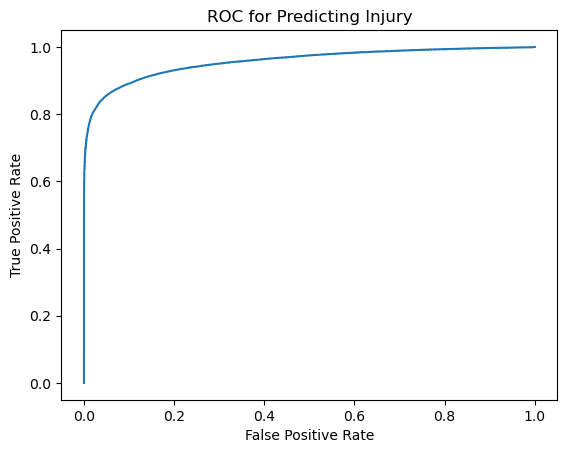


With all 3 Feature Sets, covering from pre-departuer to arrival at the gate, we get a 95.65%  Accuracy rating.
Though this is a very good AUC score, it is not very realistic for prediction prior to take-off.


In [9]:
# Columns to use as Features
fs123 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime', 'AirTime', 'ArrTarmacTime']


# Run Logistic Regression Model using feature sets 1, 2, and 3
fs123_binom_model = run_logreg_model(flights_df, fs123)

print('')
print('With all 3 Feature Sets, covering from pre-departuer to arrival at the gate, we get a 95.65%  Accuracy rating.')
print('Though this is a very good AUC score, it is not very realistic for prediction prior to take-off.')


# Logistic Regression with Feature Set 1 & 2

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257334
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83425.
Date:                Tue, 05 Dec 2023   Deviance:                   1.6685e+05
Time:                        15:11:00   Pearson chi2:                 2.12e+06
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5219
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

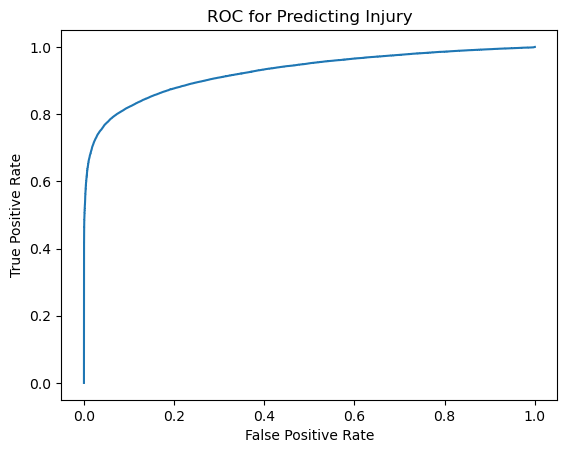


With a reduced feature set that excludes Arrival information, we are able to get an AUC score of 92.56%.
This is not quite as good, but more useful to determine the likelihood of a flight being delayed once we know the departure information.


In [10]:
# Columns to use as Features
fs12 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime']

# Run Logistic Regression Model using feature sets 1 adn 2
fs12_binom_model = run_logreg_model(flights_df, fs12)


print('')
print('With a reduced feature set that excludes Arrival information, we are able to get an AUC score of 92.56%.')
print('This is not quite as good, but more useful to determine the likelihood of a flight being delayed once we know the departure information.')


# Logistic Regression with Feature Set 1

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257335
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7284e+05
Date:                Tue, 05 Dec 2023   Deviance:                   3.4568e+05
Time:                        15:11:43   Pearson chi2:                 2.63e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04208
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

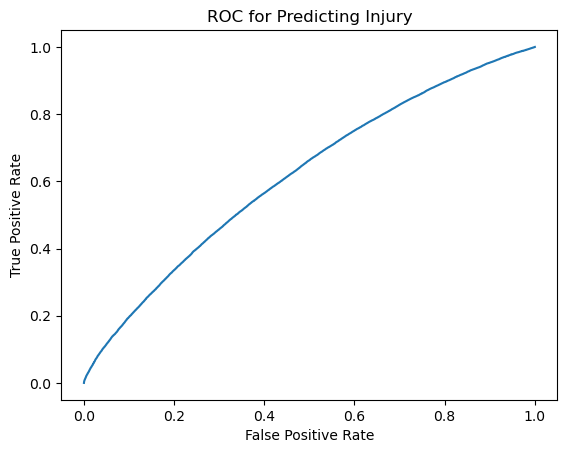


Removing the Feature Set 2 data, we get an AUC score of 61.64%.  This is not a good score, and this model is not very useful in this state.


In [13]:
# Columns to use as Features
fs1 = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone']

# Run Logistic Regression Model using feature sets 1
fs1_binom_model = run_logreg_model(flights_df, fs1)


print('')
print('Removing the Feature Set 2 data, we get an AUC score of 61.64%.  This is not a good score, and this model is not very useful in this state.')

# Testing with 2023 Data

The below code preps a Logistic Regression model using Feature Set 1 without weather data, and attempts to test it using data taken from 2023.  Since this data was outside the original data used in the modeling, it is a good test to evaluate model performance with data it has never seen. 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257338
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7389e+05
Date:                Tue, 05 Dec 2023   Deviance:                   3.4778e+05
Time:                        15:12:02   Pearson chi2:                 2.57e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03426
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Month             

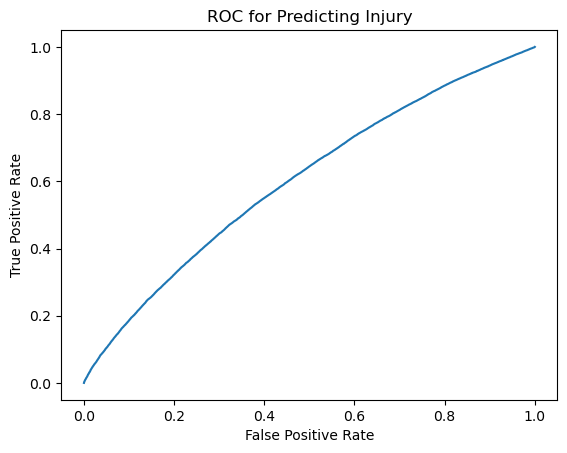


Removing the Feature Set 2 data, we get an AUC score of 60.38%.  This is not a good score, and this model is not very useful in this state.


In [14]:
# FS1 without weather data.
fs1_no_weather = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count']

# Run Logistic Regression Model using feature sets 1
fs1_no_weather_model = run_logreg_model(flights_df, fs1_no_weather)

print('')
print('Removing the Feature Set 2 data, we get an AUC score of 60.38%.  This is not a good score, and this model is not very useful in this state.')

In [5]:
# Load Test dataset (2023 Flight data)
test_df =  pd.read_csv('../data/flight_test_data.csv')

# Rename ArrDel15 to Delayed - This is the column being predicted
test_df.rename(columns={'ArrDel15':'Delayed', 'Reporting_Airline':'Carrier'}, inplace=True)

# Calculate CRS Departure Time
test_df['CRSDepTime'] = test_df.apply(lambda row: calculate_crsDeptTime(row['DepTime'], row['DepDelay']), axis=1)

# Group by 'flightdate' and 'Tail_Number' and use cumcount() to get a count within each group
test_df['Aircraft_Daily_Flight_Count'] = test_df.groupby(['FlightDate', 'Tail_Number']).cumcount() + 1

# Filter dataframe to columns needed for testing
cols = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Delayed']

test_df = test_df[cols]
test_df.head()

,Month,DayOfWeek,DayofMonth,Origin,Dest,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Carrier,Aircraft_Daily_Flight_Count,Delayed
0,1,3,11,ATL,BUF,2240.0,38,118.0,712.0,DL,1,1.0
1,1,7,22,DEN,MKE,215.0,20,135.0,896.0,WN,1,1.0
2,1,7,22,BOS,IND,1610.0,1914,184.0,818.0,YX,1,1.0
3,1,3,11,EWR,ATL,140.0,1627,147.0,746.0,DL,1,1.0
4,1,1,23,FLL,ATL,190.0,2100,120.0,581.0,WN,1,1.0


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        70000 non-null  int64  
 1   DayOfWeek                    70000 non-null  int64  
 2   DayofMonth                   70000 non-null  int64  
 3   Origin                       70000 non-null  object 
 4   Dest                         70000 non-null  object 
 5   CRSDepTime                   70000 non-null  float64
 6   CRSArrTime                   70000 non-null  int64  
 7   CRSElapsedTime               70000 non-null  float64
 8   Distance                     70000 non-null  float64
 9   Carrier                      70000 non-null  object 
 10  Aircraft_Daily_Flight_Count  70000 non-null  int64  
 11  Delayed                      70000 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 6.4+ MB


In [18]:
# Declare X and Y from dataframe
test_x = test_df[fs1_no_weather]
test_y = test_df['Delayed']

# Encoding categorical variables
test_x = binary_encode(test_x, ['Dest', 'Origin'])
test_x = pd.get_dummies(test_x, columns=['Carrier'])

# Add columns not present in test dataset due to missing Carriers
test_x['Carrier_QX'] = 0
test_x['Carrier_YV'] = 0

print(test_x.columns)

# Predict probability that given y value is 1
y_predict = fs1_no_weather_model.predict(test_x)

# Calculate AUC of model
auc = roc_auc_score(test_y, y_predict)

# Output AUC and summary
print('(AUC) GLM Logistic Regression: %.4f' % auc)
print('')
print('This AUC of .60 indicates it would not be a good model for use in predicting flight delays.')

Index(['Month', 'DayOfWeek', 'DayofMonth', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Aircraft_Daily_Flight_Count', 'Dest_0',
       'Dest_1', 'Dest_2', 'Dest_3', 'Dest_4', 'Dest_5', 'Dest_6', 'Dest_7',
       'Dest_8', 'Origin_0', 'Origin_1', 'Origin_2', 'Origin_3', 'Origin_4',
       'Origin_5', 'Origin_6', 'Origin_7', 'Origin_8', 'Carrier_9E',
       'Carrier_AA', 'Carrier_AS', 'Carrier_B6', 'Carrier_DL', 'Carrier_F9',
       'Carrier_G4', 'Carrier_HA', 'Carrier_MQ', 'Carrier_NK', 'Carrier_OH',
       'Carrier_OO', 'Carrier_UA', 'Carrier_WN', 'Carrier_YX', 'Carrier_QX',
       'Carrier_YV'],
      dtype='object')
(AUC) GLM Logistic Regression: 0.6000

This AUC of approximately 50% indicates it would not be a good model for use in predicting flight delays.


# Logistic Model on Full 3-Year Data Set

The below section tests the Logistic Regression model with a larger dataset to see what effect a larger dataset would have on the model.  This larger dataset is made up of 3 years worth of flight data (2020, 2021, 2022) contains all delayed flights, and a proportionate number of ontime flights (not the full set due to data imbalances).  ~60% ontime and 40% delayed

In [22]:
# Load larger dataset
all_flights_df = pd.read_csv('../data/flight_data_large_balanced.csv')

# Drop columns that are missing data
all_flights_df = all_flights_df.dropna()

# Rename ArrDel15 to Delayed - This is the column being predicted
all_flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

# Filter dataset to columns to use for this experiment with the larger dataset
cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Dest', 'Origin', 'Distance', 'Carrier',
        'Full-time', 'Part-time', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Delayed']
all_flights_df = all_flights_df[cols]


all_flights_df.head()

,Month,DayofMonth,DayOfWeek,Dest,Origin,Distance,Carrier,Full-time,Part-time,CRSDepTime,CRSArrTime,CRSElapsedTime,Delayed
0,1,1,3,ORD,FAT,1730.0,UA,80145.0,11892.0,-54.0,507,241.0,1.0
1,1,1,3,PHX,KOA,2860.0,AA,95612.0,11840.0,-5.0,833,338.0,1.0
2,1,1,3,RDU,DEN,1436.0,F9,4957.0,63.0,5.0,527,202.0,0.0
3,1,1,3,MKE,ATL,669.0,DL,80582.0,10245.0,-85.0,2340,125.0,1.0
4,1,1,3,LBB,DFW,282.0,YV,3512.0,14.0,-85.0,2345,70.0,1.0


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257338
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7440e+05
Date:                Tue, 05 Dec 2023   Deviance:                   3.4880e+05
Time:                        15:22:07   Pearson chi2:                 2.57e+05
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03042
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Month             -0.0020      0.001     -1.

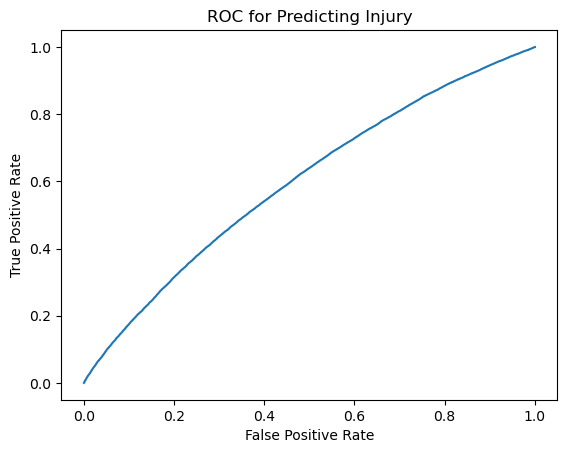


Removing the Feature Set 2 data, we get an AUC score of 61.59%.  This is not a good score, and this model is not very useful in this state.


In [23]:
features = ['Month', 'DayofMonth', 'DayOfWeek', 'Dest', 'Origin', 'Distance', 'Carrier', 
            'Full-time', 'Part-time', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']

# Run Logistic Regression Model using feature sets 1
large_model = run_logreg_model(all_flights_df, features)

# Print Summary
print('')
print('Removing the Feature Set 2 data, we get an AUC score of 61.59%.  This is not a good score, and this model is not very useful in this state.')

# PerfectSeparationError: Perfect separation detected, results not available